If you want to normalize input data, type 1, otherwise 0 (0 is default):  1
Set the noise level: 0.5 is low, 2.0 is high (1.0 is default):  1


Norm =  1 ,  Noise =  1.0


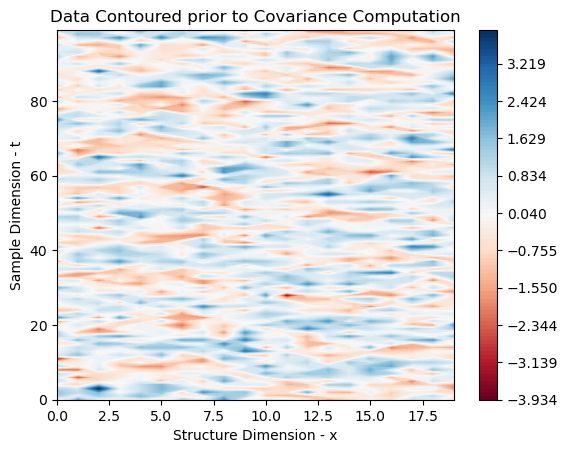

shape E (20, 20)
shape D (20,)
mean alpha =  0.1551964668600565 ,  max alpha =  0.3905464988611768
ralph =  0.2728714828606167 ,  tau =  0.7699685451593623
Nstar =  172.28042882246817


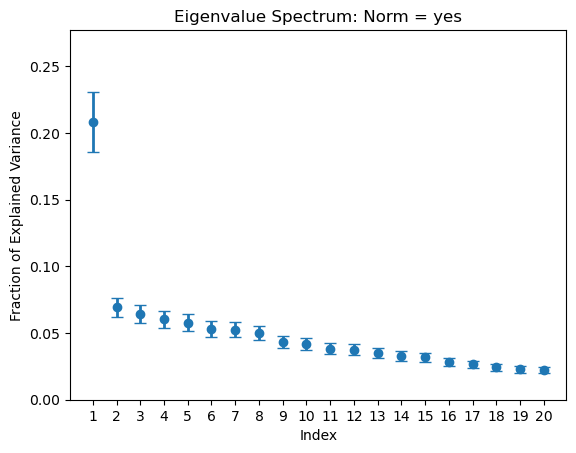

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters  you have to press return twice, or optionally enter a couple of options below
norm = int(input('If you want to normalize input data, type 1, otherwise 0 (0 is default): ') or 0)
xnoise = float(input('Set the noise level: 0.5 is low, 2.0 is high (1.0 is default): ') or 1.0)
print('Norm = ',norm,',  Noise = ',xnoise)
N = 200
M = 20
per = 12.0
yes = 'yes'
no = 'no '
ans = 'no '

if norm == 1:
    ans = yes

# Construct Data Set
x = np.zeros((M, N))
for i in range(1, N + 1):
    for j in range(1, M + 1):
        x[j - 1, i - 1] = 5.0 * (j / M) * (np.sin(2 * np.pi * (j - 1) / (M - 1)) * np.sin(2 * np.pi * i / per) + xnoise * np.random.randn())
xm = x.copy()

# Remove Mean and (Optionally) Divide by Standard Deviation
for j in range(M):
    xbar = np.mean(x[j, :])
    if norm == 1:
        sdev = np.std(x[j, :])
    else:
        sdev = 1
    xm[j, :] = (x[j, :] - xbar) / sdev

# Plot Contour Plot
fig, ax = plt.subplots()
maxc = np.max(np.abs(xm))
contour = ax.contourf(xm[:, :100].T, levels=np.linspace(-maxc, maxc, 100), cmap='RdBu')
ax.set_xlabel('Structure Dimension - x')
ax.set_ylabel('Sample Dimension - t')
plt.colorbar(contour)
plt.title('Data Contoured prior to Covariance Computation')
plt.show()

# Calculate Covariance Matrix
C = np.dot(xm, xm.T) / N

# Do Eigenanalysis
#D, E = np.linalg.eig(C)  # E eigenvector matrix D=eigenvalue vector
# using SVD of Covariance here because eig does not order eigenvalues exceptionally well.
# try it and see
E, D, V = np.linalg.svd(C)  # E eigenvector matrix D=eigenvalue vector
print('shape E', np.shape(E))
print('shape D', np.shape(D))

# Calculate Autocorrelation
alpha = np.zeros((M,))
for j in range(M):
    # Computing autocorrelation by simple vector inner product
    alpha[j] = np.sum(xm[j, :-2] * xm[j, 1:-1]) / (np.var(xm[j, :]) * N)
#print('alpha = ',alpha)


# The temporal autocorrelation is different for each spatial grid point.
# Let's use the mean of the mean and the maximum autocorrelation.
mean_alpha = np.mean(np.abs(alpha), axis=0)
max_alpha = np.max(np.abs(alpha), axis=0)
print('mean alpha = ',mean_alpha,',  max alpha = ',max_alpha)


# Conservative  I am using the average of the average and the maximum autocorrelation over the state space.
ralph = (np.mean(np.abs(alpha[:, ])) + np.max(alpha[:, ])) / 2.0
tau = -1.0 / np.log(ralph)
print('ralph = ',ralph,',  tau = ',tau)

# Bretherton, et al. 1999
Nstar = N * (1 - ralph * ralph) / (1 + ralph * ralph)
print('Nstar = ',Nstar)
# North et al 95% limits on the eigenvalues
factor = np.sqrt(2.0 / Nstar)

# Plot Eigenvalues with North et al Whiskers
L = D / np.sum(D)  # I am using fraction of variance instead of raw eigenvalue
LE = L * factor   # North confidence limits on eigenvalue
#print('L = ', L)
#print('LE = ', LE)
fig, ax = plt.subplots()
ind = np.arange(1, M + 1)
ax.errorbar(ind, L, LE, linewidth=2,fmt='o', capsize=4)
ax.set_xlabel('Index')
ax.set_ylabel('Fraction of Explained Variance')
ax.set_title(f'Eigenvalue Spectrum: Norm = {ans}')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ylimax = np.max(L+LE)*1.2
ax.set_ylim(0, ylimax)
plt.show()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


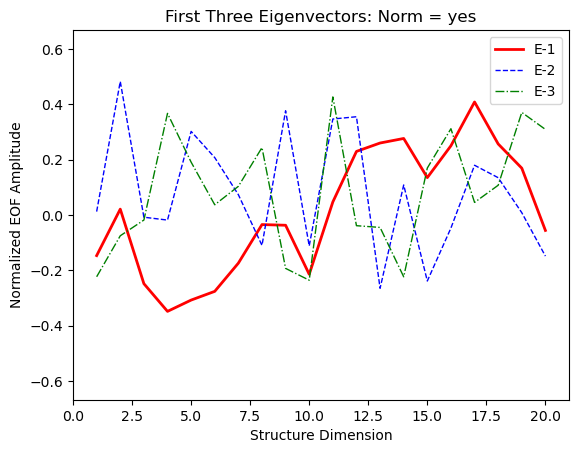

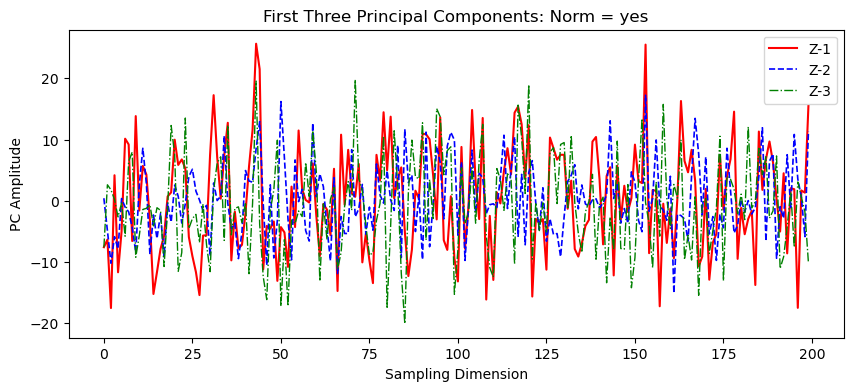

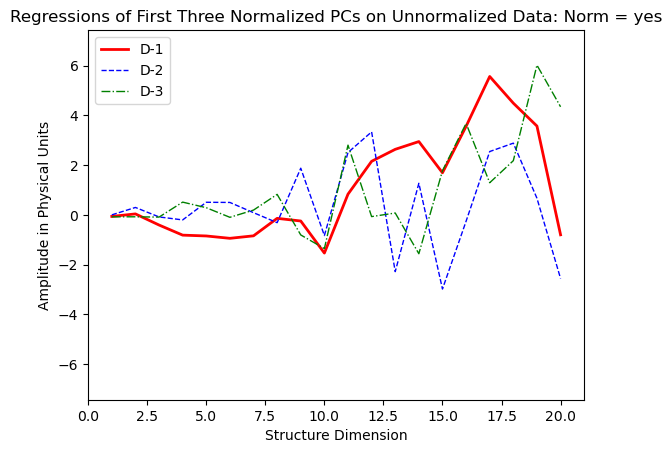

In [36]:
# Plot Eigenvectors
xindex =np.linspace(1,20,20)
print(xindex)
fig, ax = plt.subplots()
MP = M + 1
ax.plot(xindex,E[:,0], 'r', linewidth=2,label='E-1')
ax.plot(xindex,E[:, 1], 'b--', linewidth=1,label='E-2')
ax.plot(xindex,E[:, 2], 'g-.', linewidth=1,label='E-3')
ax.set_xlim(0, MP)
xmax1 = np.max(np.abs(E)) * 1.05
ax.set_ylim(-xmax1, xmax1)
ax.set_xlabel('Structure Dimension')
ax.set_ylabel('Normalized EOF Amplitude')
ax.set_title(f'First Three Eigenvectors: Norm = {ans}')
plt.legend( loc='best')
plt.legend().set_visible(True)
plt.show()

# Project Eigenvectors onto Original Data to Get PCs
Z = np.dot(E.T, x)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(Z[0, :], 'r', linewidth=1.5,label='Z-1')
ax.plot(Z[1, :], 'b--', linewidth=1.2,label='Z-2')
ax.plot(Z[2, :], 'g-.', linewidth=1.0,label='Z-3')
ax.set_xlabel('Sampling Dimension')
ax.set_ylabel('PC Amplitude')
ax.set_title(f'First Three Principal Components: Norm = {ans}')
plt.legend( loc='best')
plt.legend().set_visible(True)
plt.show()

# Normalize Principal Components Time Series to Have Zero Mean and Unit Variance
ZM = Z.copy()
for j in range(M):
    zbar = np.mean(Z[j, :])
    sdev = np.std(Z[j, :])
    ZM[j, :] = (Z[j, :] - zbar) / sdev


# Remove mean from original, unnormalized data time series
xm = np.zeros((M, N))
for i in range(N):
    for j in range(M):
        xbar = np.mean(x[j, :])
        xm[j, i] = x[j, i] - xbar

# Project data onto normalized PC time series
EM = np.dot(xm, ZM.T) / N


# Plot first three-dimensional eigenvector regressions
fig, ax = plt.subplots()
ax.plot(xindex,EM[:, 0], 'r', linewidth=2,label='D-1')
ax.plot(xindex,EM[:,1], 'b--', linewidth=1,label='D-2')
ax.plot(xindex,EM[:, 2], 'g-.', linewidth=1,label='D-3')
xmax = np.max(np.abs(EM)) * 1.1
ax.set_xlim(0, MP)
ax.set_ylim(-xmax, xmax)
ax.set_xlabel('Structure Dimension')
ax.set_ylabel('Amplitude in Physical Units')
ax.set_title(f'Regressions of First Three Normalized PCs on Unnormalized Data: Norm = {ans}')
plt.legend( loc='best')
plt.legend().set_visible(True)
plt.show()
